# 03. Transfer Learning in Computer Vision with TensorFlow



In [8]:
import os
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 3.2 Multi-Class Classification of Images with Transfer Learning

If you've been thinking, "surely someone else has spent the time crafting the right model for the job..." then you're in luck. 

For many of the problems you'll want to use deep learning for, chances are, a working model already exists.

And the good news is, you can access many of them on TensorFlow Hub.

[TensorFlow Hub](https://tfhub.dev/) is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

Now, I really want to demonstrate the power of transfer learning to you.

To do so, what if I told you we could get much of the same results (or better) than our best model has gotten so far with only 10% of the original data, in other words, 10x less data.

This seems counterintuitive right?

Wouldn't you think more examples of what a picture of food looked like led to better results?

And you'd be right if you thought so, generally, more data leads to better results.

**However, what if you didn't have more data? What if instead of 750 images per class, you had 75 images per class?**

Collecting 675 more images of a certain class could take a long time.

So this is where another major benefit of transfer learning comes in.

**Transfer learning often allows you to get great results with less data.**

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

But don't just take my word for it. Let's download a subset of the data we've been using, namely 10% of the training data from the `10_food_classes` dataset and use it to train a food image classifier on.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)
*What we're working towards building. Taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset our own images.*



## 3.2.1 Dataset

In [2]:
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-06-14 18:58:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  82.2MB/s    in 2.0s    

2022-06-14 18:58:56 (82.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [4]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Excellent! Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

## 3.2.2 Setting up callbacks (things to run whilst our model trains)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is **callbacks**.

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). 

Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq='epoch'` parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

> 🔑 **Note:** We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).



In [6]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## 3.2.3 Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

In fact, we're going to use the model from TensorFlow Hub:
1. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019. We will use this version: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

You might be wondering, how do you find these models on TensorFlow Hub?

Here are the steps I took:

1. Go to [tfhub.dev](https://tfhub.dev/).
2. Choose your problem domain, e.g. "Image" (we're using food images).
3. Select your TF version, which in our case is TF2.
4. Remove all "Problem domanin" filters except for the problem you're working on. 
  * **Note:** "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
5. The models listed are all models which could potentially be used for your problem.

In [10]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  IMAGE_SHAPE = (224, 224)
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [11]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                              # Track logs under different experiment name
                                              experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220614-191336
Epoch 1/5
24/24 [==============================] - 44s 1s/step - loss: 1.8550 - accuracy: 0.4547 - val_loss: 1.3032 - val_accuracy: 0.7344
Epoch 2/5
24/24 [==============================] - 16s 697ms/step - loss: 1.0613 - accuracy: 0.7667 - val_loss: 0.8727 - val_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 16s 691ms/step - loss: 0.7640 - accuracy: 0.8307 - val_loss: 0.7024 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 15s 656ms/step - loss: 0.6125 - accuracy: 0.8653 - val_loss: 0.6120 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 18s 779ms/step - loss: 0.5183 - accuracy: 0.8893 - val_loss: 0.5601 - val_accuracy: 0.8672


In [12]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

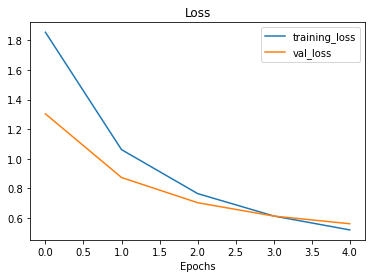

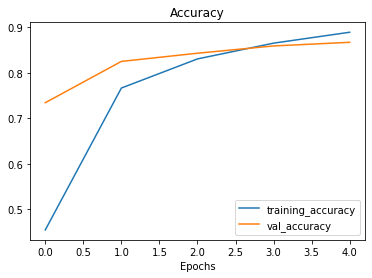

In [13]:
plot_loss_curves(efficientnet_history)

### 3.2.4 Tensorboard

In [14]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0" \
  --description "Performance of the NN using only 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=ZLisrLIkaujS7EzfpZBUcVybDUWQn0&prompt=consent&access_type=off

### 3.2.5 Make predictions

#### Example 1

In [22]:
# Load an image
imgs_test, labels_test = test_data.next()

In [23]:
imgs_test.shape

(32, 224, 224, 3)

In [27]:
img_test = imgs_test[0, ...] 
img_test.shape

(224, 224, 3)

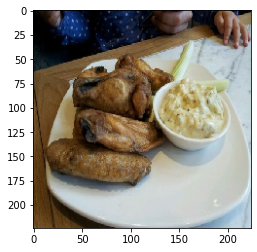

In [29]:
plt.imshow((img_test * 255.).astype(np.uint8))

In [30]:
# Pass the random tensor through a global average pooling 2D layer
input_tensor = imgs_test[0:1, ...]
out_efficient = efficientnet_model(input_tensor)
print(f"2D global average pooled random tensor:\n {out_efficient}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of output tensor: {out_efficient.shape}")

2D global average pooled random tensor:
 [[0.07035269 0.3541902  0.03501467 0.1057248  0.21060999 0.06649747
  0.00920256 0.01611624 0.07136922 0.06092208]]

Shape of input tensor: (1, 224, 224, 3)
Shape of output tensor: (1, 10)


In [36]:
# Predict the class
index_of_max_prediction = tf.argmax(out_efficient, axis=1).numpy().item()
dict_classes = {v:k for k,v in test_data.class_indices.items()}
print(f'Predicted class:', dict_classes[index_of_max_prediction])

Predicted class: chicken_wings


#### Example 2

Predicted class: fried_rice


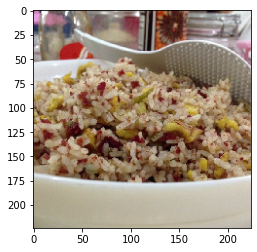

In [39]:
# Load an image
imgs_test, labels_test = test_data.next()
img_test = imgs_test[0, ...] 
plt.imshow((img_test * 255.).astype(np.uint8))

# Pass the random tensor through a global average pooling 2D layer
input_tensor = imgs_test[0:1, ...]
out_efficient = efficientnet_model(input_tensor)

# Predict the class
index_of_max_prediction = tf.argmax(out_efficient, axis=1).numpy().item()
dict_classes = {v:k for k,v in test_data.class_indices.items()}
print(f'Predicted class:', dict_classes[index_of_max_prediction])

#### Example 3

Predicted class: pizza


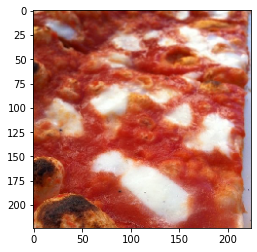

In [40]:
# Load an image
imgs_test, labels_test = test_data.next()
img_test = imgs_test[0, ...] 
plt.imshow((img_test * 255.).astype(np.uint8))

# Pass the random tensor through a global average pooling 2D layer
input_tensor = imgs_test[0:1, ...]
out_efficient = efficientnet_model(input_tensor)

# Predict the class
index_of_max_prediction = tf.argmax(out_efficient, axis=1).numpy().item()
dict_classes = {v:k for k,v in test_data.class_indices.items()}
print(f'Predicted class:', dict_classes[index_of_max_prediction])